In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.interpolate as interp
import sys
import datetime
import time
from tqdm import tqdm

from   itertools         import compress 
import matplotlib.pyplot as plt
import numpy             as np
from   scipy.integrate   import trapz
from   scipy.linalg      import eig, block_diag
from   scipy.sparse      import diags

from scipy.sparse.linalg import eigs
from scipy import sparse

In [2]:
case = 'Proehl_1'; dim = '2D'; ny = 100; nz = 50; k = 5.50; mu = 0.0; init_guess=0.09+0.03*1j

In [2]:
case = 'Proehl_4'; dim = '2D'; ny = 60; nz = 50; k = 8.85e-6; mu = 0.0; init_guess= -0.3+0.1*1j

## Definitions

In [6]:
def gaussian_jet(Y, Z, mean_flow):
    """
    Define a Gaussian jet for the mean zonal velocity
    
    Parameters
    ----------
    
    Y : (ny, nz) array
        Meridional component of the meshgrid
    
    Z : (ny, nz) array
        Vertical component of the meshgrid
    
    maximum : float
        Amplitude of the Gaussian jet
    
    y_center : float
        Meridional center of the jet
    
    z_center : float
        Vertical center of the jet 
        
    y_decay : float
        Meridional decay scale for the gaussian jet
    
    z_decay : float
        Vertical decay scale for the gaussian jet
    
    Returns
    -------
    
    U : (ny, nz) array
        Two-dimensional Gaussian jet
    
    Uy : (ny, nz) array
        Meridional derivative of U
    
    Uz : (ny, nz) array
        Vertical derivative of U
    """
    
    if mean_flow == 'Proehl_1':
        y_center = 0; z_center = -500; maximum = 1.5; y_decay = 100*1000; z_decay = 100 
        
        U  = maximum*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        Uy = -(maximum*(Y-y_center)/(y_decay**2))*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        Uz = -(maximum*(Z-z_center)/(z_decay**2))*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        
    elif mean_flow == 'Proehl_2':
        y_center = 0; z_center = -500; maximum = -1.5; y_decay = 100*1000; z_decay = 100 
        
        U  = maximum*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        Uy = -(maximum*(Y-y_center)/(y_decay**2))*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        Uz = -(maximum*(Z-z_center)/(z_decay**2))*np.exp(-((Y-y_center)**2)/(2*(y_decay**2))-((Z-z_center)**2)/(2*(z_decay**2)))  
        
    elif mean_flow == 'Proehl_3':            
        secs_y_center = -(4*111)*1000; secs_z_center = 0;  secs_maximum = -0.5; secs_decay_y = 100*1000; secs_decay_z = 100
        secn_y_center = (4*111)*1000;  secn_z_center = 0;  secn_maximum = -0.5; secn_decay_y = 100*1000; secn_decay_z = 100

        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2))))
        U    = SECS + SECN; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    elif mean_flow == 'Proehl_4':
        secs_y_center = -200*1000; secs_z_center = 0;  secs_maximum = -0.5; secs_decay_y = 100*1000; secs_decay_z = 200
        secn_y_center = 200*1000;  secn_z_center = 0;  secn_maximum = -0.5; secn_decay_y = 100*1000; secn_decay_z = 200

        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2))))
        U    = SECS + SECN; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    elif mean_flow == 'Proehl_5':
        secs_y_center = -200*1000; secs_z_center = 0;     secs_maximum = -0.5; secs_decay_y = 100*1000; secs_decay_z = 200 
        euc_y_center  = 0;          euc_z_center = -120;   euc_maximum = 1.0;   euc_decay_y = 125*1000;  euc_decay_z = 75
        secn_y_center = 200*1000;  secn_z_center = 0;     secn_maximum = -0.5; secn_decay_y = 100*1000; secn_decay_z = 200 

        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        EUC  = euc_maximum*np.exp(-(((Y-euc_y_center)**2)/(2*(euc_decay_y**2)))-(((Z-euc_z_center)**2)/(2*(euc_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2)))) 
        U    = SECS + EUC + SECN; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    elif mean_flow == 'Proehl_6':
        secs_y_center = -200*1000; secs_z_center = 0;     secs_maximum = -0.3; secs_decay_y = 100*1000; secs_decay_z = 200 
        euc_y_center  = 0;          euc_z_center = -120;   euc_maximum = 1.0;   euc_decay_y = 125*1000;  euc_decay_z = 75
        secn_y_center = 200*1000;  secn_z_center = 0;     secn_maximum = -0.7; secn_decay_y = 100*1000; secn_decay_z = 200 
        
        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        EUC  = euc_maximum*np.exp(-(((Y-euc_y_center)**2)/(2*(euc_decay_y**2)))-(((Z-euc_z_center)**2)/(2*(euc_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2)))) 
        U    = SECS + EUC + SECN; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    elif mean_flow == 'Proehl_7':
        secs_y_center = -300*1000; secs_z_center = 0;     secs_maximum = -0.3; secs_decay_y = 200*1000; secs_decay_z = 250 
        euc_y_center  = 0;          euc_z_center = -120;   euc_maximum = 1.0;   euc_decay_y = 125*1000; euc_decay_z  = 75
        secn_y_center = 200*1000;  secn_z_center = 0;     secn_maximum = -0.7; secn_decay_y = 100*1000; secn_decay_z = 150 

        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        EUC  = euc_maximum*np.exp(-(((Y-euc_y_center)**2)/(2*(euc_decay_y**2)))-(((Z-euc_z_center)**2)/(2*(euc_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2)))) 
        U    = SECS + EUC + SECN; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    elif mean_flow == 'Proehl_8':
        secs_y_center = -300*1000; secs_z_center = 0;     secs_maximum = -0.3; secs_decay_y = 200*1000; secs_decay_z = 250 
        euc_y_center  = 0;          euc_z_center = -120;   euc_maximum = 1.0;   euc_decay_y = 125*1000; euc_decay_z  = 75
        secn_y_center = 200*1000;  secn_z_center = 0;     secn_maximum = -0.7; secn_decay_y = 100*1000; secn_decay_z = 150 
        necc_y_center = 600*1000;  necc_z_center = 0;     necc_maximum = 0.5;  necc_decay_y = 150*1000; necc_decay_z = 250

        SECS = secs_maximum*np.exp(-(((Y-secs_y_center)**2)/(2*(secs_decay_y**2)))-(((Z-secs_z_center)**2)/(2*(secs_decay_z**2))))
        SECN = secn_maximum*np.exp(-(((Y-secn_y_center)**2)/(2*(secn_decay_y**2)))-(((Z-secn_z_center)**2)/(2*(secn_decay_z**2))))
        EUC  = euc_maximum*np.exp(-(((Y-euc_y_center)**2)/(2*(euc_decay_y**2)))-(((Z-euc_z_center)**2)/(2*(euc_decay_z**2))))
        NECC = necc_maximum*np.exp(-(((Y-necc_y_center)**2)/(2*(necc_decay_y**2)))-(((Z-euc_z_center)**2)/(2*(necc_decay_z**2))))
        U    = SECS + EUC + SECN + NECC; Uy = np.gradient(U, Y[0,:], axis=1); Uz = np.gradient(U, Z[:,0], axis=0)
        
    else:
        raise ValueError(f'{case} is not a valid option for a mean flow')
    
    return U, Uy, Uz

def tridiag(subdiag, diag, supdiag, bc):
    """
    Create a tridiagonal matrix of the form
    
    |  bc[0]           bc[1]           0              0           0            ...               .                   0          |
    |subdiag[0]      diag[1]       supdiag[1]         0           0            ...               .                   0          |
    |    0          subdiag[1]      diag[2]       supdiag[2]      0            ...               .                   0          |
    |    0               0         subdiag[2]      diag[3]    supdiag[3]       ...               .                   0          |
    |    .               .             .              .           .            ...               .                   .          |
    |    .               .             .              .           .            ...               .                   .          |
    |    .               .             .              .           .            ...               .                   0          |
    |    0               .             .              .           .       subdiag[-2]       diag[-2]           supdiag[-1]      |
    |    0               0             0              0           0             0              bc[2]               bc[3]        |
    
    This allows us to easily implement the vertical boundary conditions
                        
    Parameters
    ----------
    
    subdiag : float
        Elements on the subdiagonal of the tridagonal matrix
        
    diag : float
        Elements on the diagonal of the tridiagonal matrix
        
    supdiag : float
        Elements on the superdiagonal of the tridiagonal matrix
        
    bc : list of floats
        Entries corresponding to boundary conditions
        
    Returns
    -------
    
    tri_matrix : matrix
        Tridiagonal matrix 
    """
    
    # Create a diagonal matrix with tridiagonal entries and then convert to a regular numpy array
    tri_matrix = diags([subdiag, diag, supdiag],[-1, 0, 1]).toarray()
    
    # Add entries corresponding to boundary conditions
    tri_matrix[0, 0]   = bc[0]; tri_matrix[0, 1]   = bc[1]
    tri_matrix[-1, -2] = bc[2]; tri_matrix[-1, -1] = bc[3]
    
    return tri_matrix

def write_matrices(matrices):
    """
    Write the matrices that build the generalised eigenvalue problem into text files
    
    Parameters
    ----------
    
    output : boolean
        if True then print the list of matrices to text files
        
    matrices : list of str
        Names of the matrices to be printed to text files
    """
    
    matrix_name = ['ZLU', 'ZLV0', 'ZLV1', 'ZLV2', 'ZLV', 'ZLP0', 'ZLP1', 'ZLP', 'ZRU', 'ZRP1', 'ZRP', 'MLU', 'MLV', 'MLP', 'MRV', 'CLU', 'CLV0', 'CLV1', 'CLV', 'CLP', 'CRP']
    for num, matrix in tqdm(enumerate(matrices)):
        with open(os.getcwd()+'\\outputs'+f'\\{matrix_name[num]}.txt', 'w') as f: # write to the outputs file 
            for item in matrix:
                f.write("%s\n" % item)
                    
    else:
        pass

def clean_evals(A, B, evals, vl, evecs, suppress):
    """
    Clean the eigenvalue spectrum by deleting eigenvalues that:
    (i)   Have infinite real part
    (ii)  Are ill-conditioned wrt some tolerance
    (iii) Do not satisfy the generalised eigenvalue problem
                        
    Parameters
    ----------
    
    A : (N, N) matrix
        LHS matrix of the generalised eigenvalue problem
        
    B : (N, N) matrix
        RHS matrix of the generalised eigenvalue problem

    evals : (N, ) array
        Eigenvalue spectrum of the generalised eigenvalue problem
        
    vl : (N, N) array
        Left eigenvectors of the generlaised eigenvalue problem
        
    evecs : (N, N) array
        Right eigenvectors of the generalised eigenvalue problem
        
    suppress : boolean
        if False then output print statements 
        
    Returns
    -------
    
    evals : complex array
        Cleaned eigenvalue spectrum
    
    cs : complex float
        Most unstable eigenvalue of evals
    
    evecs : complex array
        Eigenvector corresponding to the most unstable eigenvalue
    
    """
    
    if suppress == False:
        print(f'\nTotal number of eigenvalues                  : {evals.shape[0]}')
    else:
        pass
    
    # Clean the eigenspectrum by checking (i) Finite eigenvalues (ii) Equality and (iii) Condition number ------------
    
    # (i)
    # Create a list of arguments of finite eigenvalues and retain only those eigenpairs which are finite
    finite_args = list(np.where(evals.real!=np.inf)[0])
    
    if suppress == False:
        print(f'Number of infinite eigenvalues               : {evals.shape[0]-len(finite_args)}')
    
    evals = evals[finite_args]; vl = vl[:, finite_args]; evecs = evecs[:, finite_args]
    
    # (ii)
    # For each eigenvalue/eigenvector pair, compare the LHS and RHS of the generalised eigenvalue problem and 
    # create a list of all those pairs which do satisfy the equality
    equality_check = [np.allclose(A@evecs[:, i], evals[i]*B@evecs[:, i]) for i in range(evecs.shape[1])] 
    args           = list(compress(range(len(equality_check)), equality_check))
    
    # Note that these print statements are not representative of the entire eigenvalue spectrum since
    # we have already neglected eigenvalues with an infinite real part
    if suppress == False:
        print(f'Number of eigenpairs not satisfying equality : {evals.shape[0]-len(args)}')

    # Retain only the eigenvalues/eigenvectors (and left eigenvectors) that satisfy this equality
    evals = evals[args]; vl = vl[:, args]; evecs = evecs[:, args]
    
    # (iii)
    # Calculate the condition number of the eigenvalues and create a list of all those eigenpairs which have 
    # a condition number less than the specified condition number tolerance (cond_num)
    eval_cond = abs(1/np.diag(np.dot(vl.T, evecs)))
    cond_args = list(np.where(eval_cond<1e3)[0])
    
    if suppress == False:
        print(f'Number of poorly conditioned eigenvalues     : {evals.shape[0]-len(cond_args)}')

    # Retain only the eigenvalue/eigenvectors (we do not need left eigenvectors anymore) that have a 
    # sufficiently small condition number
    evals = evals[cond_args]; evecs = evecs[:, cond_args]
    
    if suppress == False:
        print(f'Number of accurately calculated eigenvalues  : {evals.shape[0]}')
    
    # If evals is empty, then there are no finite well-conditioned eigenvalues
    # Output an error suggesting that we need to try a larger tolerance on the condition number
    if not len(evals):
        raise ValueError(f'There are no finite well-conditioned eigenvalues within the specified tolerance.'+ 
                         f'Try a larger condition number tolerance of at least {np.ceil(np.amin(eval_cond))}')
    
    # Obtain the eigenvalue and eigenvector that corresponds to the most unstable mode---------------
    cs     = evals[np.argmax(evals.imag)]
    evecs  = evecs[:, np.argmax(evals.imag)]
    
    return evals, evecs, cs

## Solver

In [7]:
def gep(ny, nz, k, mu, case, dim, init_guess):  
    
    ########################################################################################################################################################################################################
    # (i) Set up the domain
    ########################################################################################################################################################################################################
        
    if dim == '1D_M':
        if case == 'RK':
            d = 1e6; L = np.pi*d
            y = np.linspace(-L, L, ny); dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
            
        else:
            raise ValueError(f'{case} is not a valid case for a {dim} problem')    
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            L = 1
            z = np.linspace(0, L, nz); dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1] 
        
        else:
            raise ValueError(f'{case} is not a valid case for a {dim} problem')
    
    elif dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8'
        ):
            L = (10*111.32)*1000 # Meridional half-width of the domain (m)
            D = 1000             # Depth of the domain (m)
            
            y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 
        
        elif case == 'RK':
            d = 1e6; L = np.pi*d
            D = 1000  
            
            y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 
        
        elif case == 'EADY' or case == 'STONE':
            L = 1
            D = 1

            y = np.linspace(-L, L, ny);  z = np.linspace(0, D, nz)
            
        else:
            raise ValueError(f'{case} is not a valid case for a {dim} problem')

        dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
        dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]

        Y,Z         = np.meshgrid(y, z);         Y_full,Z_half = np.meshgrid(y, z_mid) 
        Y_mid,Z_mid = np.meshgrid(y_mid, z_mid); Y_half,Z_full = np.meshgrid(y_mid, z)
        
    ########################################################################################################################################################################################################
    # (ii) Specify the mean zonal flow
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            beta = 2.29e-11; V = (beta*(L**2))
            
            U  = (V/2)*(1+np.cos((y/d)));  U_mid = (V/2)*(1+np.cos((y_mid/d)))
            Uy = np.gradient(U,y);        Uy_mid = np.gradient(U_mid,y_mid)
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            U  = z;                U_mid = z_mid
            Uz = np.ones_like(z); Uz_mid = np.ones_like(z_mid)
    
    elif dim == '2D':
        y_center = 0; z_center = -500; maximum = 1.5; y_decay = 100*1000; z_decay = 100 
        
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8'
        ):
            U    , Uy    , Uz     = gaussian_jet(Y     , Z     , case)
            U_mid, Uy_mid, Uz_mid = gaussian_jet(Y_mid , Z_mid , case)
            U_hf , Uy_hf , Uz_hf  = gaussian_jet(Y_half, Z_full, case)
            U_fh , Uy_fh , Uz_fh  = gaussian_jet(Y_full, Z_half, case)
        
        elif case == 'EADY' or case == 'STONE':
            U_mid = Z_mid; U_fh = Z_half; U_hf = Z_full
            Uy_hf = np.zeros_like(U_hf); Uy_mid = np.zeros_like(U_mid)
            Uz_hf = np.ones_like(U_hf);  Uz_mid = np.ones_like(U_mid)
            
        elif case == 'RK':
            beta = 2.29e-11; V = (beta*(L**2))
            
            U_mid = (V/2)*(1+np.cos(np.pi*Y_mid/L)); Uy_mid = np.gradient(U_mid, y_mid, axis=1); Uz_mid = np.gradient(U_mid, z_mid, axis=0)
            U_hf  = (V/2)*(1+np.cos(np.pi*Y_half/L)); Uz_hf = np.gradient(U_hf, z, axis=0)
            U_fh  = (V/2)*(1+np.cos(np.pi*Y_full/L)); 

    # U_mid = U evaluated at half points in y and half points in z
    # U_fh  = U evaluated at (f)ull points in y and (h)alf points in z
    # U_hf  = U evaluated at (h)alf points in y and (f)ull points in z
    
    ########################################################################################################################################################################################################
    # (iii) Typical dimensional parameters 
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            pass
            
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            # Typical values for a midlatitude atmosphere
            Ri  = 1.0                # Richardson number   
            f0  = 1.0e-4             # Coriolis frequency (s^{-1})
            H   = 10*1000.0          # Height of tropopause (m)
            N   = 1.0e-2             # Buoyancy frequency (s^{-1})
            V   = N*H/(np.sqrt(Ri))  # Velocity (ms^{-1})
            L   = V/f0               # Length Scale (m)
            eps = V/(f0*L)           # Rossby Number  
            S   = ((N*H)/(f0*L))**2  # Stratification Parameter
    
    elif dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8'
        ):
            # Typical values for the equatorial ocean 
            beta   = 2.29e-11          # Meridional gradient of the Coriolis parameter (m^{-1}s^{-1})
            N2     = 8.883e-5;         # Buoyancy frequency (s^{-2}) (as in Proehl 96/98)
            N      = np.sqrt(N2)       #
            Leq    = np.sqrt(N*D/beta) # Equatorial internal-deformation radius (m)
            r0     = 1026              # Background density (kg m^{3})
            g      = 9.81              # Gravitational acceleration (ms^{-2})
            V      = np.amax(abs(U))   # Absolute maximum of mean zonal flow (ms^{-1})
            eps    = V/(beta*(Leq**2)) # Equatorial Rossby number 
            
        elif case == 'RK':
            beta   = 2.29e-11          # Meridional gradient of the Coriolis parameter (m^{-1}s^{-1})
            N2     = 8.883e-5;         # Buoyancy frequency (s^{-2}) (as in Proehl 96/98)
            N      = np.sqrt(N2)       #
            r0     = 1026              # Background density (kg m^{3})
            g      = 9.81              # Gravitational acceleration (ms^{-2})
            eps    = V/(beta*(L**2)) # Equatorial Rossby number 

        elif case == 'EADY' or case == 'STONE':
            # Typical values for a midlatitude atmosphere
            Ri  = 1.0                # Richardson number   
            f0  = 1.0e-4             # Coriolis frequency
            H   = 10*1000.0          # Height of tropopause (m)
            N   = 1.0e-2             # Buoyancy frequency
            V   = N*H/(np.sqrt(Ri))  # Velocity
            L   = V/f0               # Length Scale
            eps = V/(f0*L)           # Rossby Number  
            S   = ((N*H)/(f0*L))**2  # Stratification Parameter
        
    ########################################################################################################################################################################################################
    # (iv) Calculate the mean density profile 
    ########################################################################################################################################################################################################
        
    if dim == '1D_M':
        if case == 'RK':
            pass
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            ry = Uz; rz = (-S/eps)*np.ones(nz)
            
        else:
            raise ValueError(f'TBC')
            
    elif dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK'
        ):
            # Calculate the mean density profile (by thermal wind balance)
            r = np.zeros((nz, ny-1), dtype=np.float64)
            for l in range(nz):
                for j in range(ny-1):
                    r[l, j] = (beta*r0/g)*trapz((Y_half*Uz_hf)[l, :j],dx=dy)

            r  = r - np.tile((N2*r0/g)*z, (len(y)-1, 1)).T 
            ry = (beta*r0/g)*Y_half*Uz_hf; rz = np.gradient(r, z, axis=0)
        
        elif case == 'EADY' or case == 'STONE':
            ry = Uz_hf; rz = (-S/eps)*np.ones_like(U_hf)
            
        else:
            raise ValueError(f'{case} is not a valid case for a {dim} problem')
            
    ########################################################################################################################################################################################################
    # (v) Non-dimensionalise the equations of motion (only relevant for the TIW problem) 
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            y = y/L; dy = abs(y[1]-y[0]); y_mid = y_mid/L; 
            U = U/V; U_mid = U_mid/V; Uy = (L/V)*Uy; Uy_mid = (L/V)*Uy_mid
        
    elif dim == '1D_V':
        pass
    
    elif dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8'
        ): 
            y = y/Leq; y_mid = y_mid/Leq; dy = abs(y[1]-y[0])
            z = z/D;   z_mid = z_mid/D;   dz = abs(z[1]-z[0])

            U_hf  = U_hf/V; U_fh = U_fh/V

            U_mid = U_mid/V; Uy_mid = (Leq/V)*Uy_mid; Uz_mid = (D/V)*Uz_mid  

            ry = (g*D/(r0*beta*Leq*V))*ry; rz = (g*(D**2)/(r0*beta*(Leq**2)*V))*rz  

            Y_mid,Z_mid = np.meshgrid(y_mid,z_mid); Y_full,Z_half = np.meshgrid(y,z_mid)
            
        elif case == 'RK':
            y = y/L; y_mid = y_mid/L; dy = abs(y[1]-y[0])
            z = z/D; z_mid = z_mid/D; dz = abs(z[1]-z[0])

            U_hf  = U_hf/V; U_fh = U_fh/V

            U_mid = U_mid/V; Uy_mid = (L/V)*Uy_mid; Uz_mid = (D/V)*Uz_mid  

            ry = (g*D/(r0*beta*L*V))*ry; rz = (g*(D**2)/(r0*beta*(L**2)*V))*rz  

            Y_mid,Z_mid = np.meshgrid(y_mid,z_mid); Y_full,Z_half = np.meshgrid(y,z_mid)
            
        elif case == 'EADY' or case == 'STONE':
            pass
    
    # Form matrices from the discretised equation of motion ------------------------------------------
    # The names for each of the matrices is explained by the following examples:
    # ZLU = ((Z)onal momentum equation)((L)HS of the equation)((u) perturbation)
    # CRP = ((C)ontinuity equation)((R)HS of the equation)((p) perturbation)

    ########################################################################################################################################################################################################
    # (vi) Build the zonal momentum equation
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            ZLU = k * np.diag(U_mid) 
            
            ZLV0 = np.zeros((ny-1, ny))
            for i in range(ny-1):
                ZLV0[i][i]   = (y_mid[i]-Uy_mid[i])
                ZLV0[i][i+1] = (y_mid[i]-Uy_mid[i])
            ZLV = (1j/2)*ZLV0
            
            ZLP = k*np.eye(ny-1)

            ZRU = k*np.eye(ny-1)
            ZRV = np.zeros_like(ZLV)
            ZRP = np.zeros_like(ZLP) 
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            ZLU = eps*k*np.diag(U_mid)
            
            if case == 'EADY':
                ZLV1 = ZLP1 = ZRP1 = 0
                
            elif case == 'STONE':
                ZLV1 = tridiag((ry/rz)[1:-1], ((ry/rz)[:-1]+(ry/rz)[1:]), (ry/rz)[1:-1], [(ry/rz)[1], (ry/rz)[1], (ry/rz)[-2], (ry/rz)[-2]])
                ZLP1 = tridiag((U/rz)[1:-1] ,  -((U/rz)[:-1]-(U/rz)[1:]), -(U/rz)[1:-1], [ (U/rz)[1], -(U/rz)[1],  (U/rz)[-2], -(U/rz)[-2]])
                ZRP1 = tridiag((1/rz)[1:-1] ,  -((1/rz)[:-1]-(1/rz)[1:]), -(1/rz)[1:-1], [ (1/rz)[1], -(1/rz)[1],  (1/rz)[-2], -(1/rz)[-2]])
                
            ZLV = 1j*np.eye(nz-1) + (1j*eps/4)*ZLV1
            ZLP = k*np.eye(nz-1) - (k*eps/(2*dz))*ZLP1
            
            ZRU = eps*k*np.eye(nz-1)  
            ZRV = np.zeros_like(ZLV)
            ZRP = np.zeros_like(ZLP) - (k*eps/(2*dz))*ZRP1
                
    elif dim == '2D':
        ZLU = eps*k*np.diag(U_mid.flatten(order='F'))

        ZLV0 = np.zeros(((ny-1)*(nz-1), (ny*(nz-1)))) 
        if case == 'EADY' or case == 'STONE':
            for i in range((ny-1)*(nz-1)):                
                ZLV0[i, i]        = 1 # f plane
                ZLV0[i, i+(nz-1)] = 1 # f plane
        
        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK'
        ):  
            for i in range((ny-1)*(nz-1)):                
                ZLV0[i, i]        = Y_mid.flatten(order='F')[i] # Equatorial beta plane                          
                ZLV0[i, i+(nz-1)] = Y_mid.flatten(order='F')[i] # Equatorial beta plane

        ZLV1 = np.zeros(((ny-1)*(nz-1), (ny*(nz-1)))) 
        for i in range((ny-1)*(nz-1)):                
            ZLV1[i, i]        = (Uy_mid.flatten(order='F'))[i]                            
            ZLV1[i, i+(nz-1)] = (Uy_mid.flatten(order='F'))[i] 

        ZLV2 = np.zeros(((ny-1)*(nz-1), (ny*(nz-1)))) 
        if case == 'EADY':
            pass
        
        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK' or case == 'STONE'
        ):
            for i in range(ny-1):                        
                ZLV2[i*(nz-1):(i+1)*(nz-1), i*(nz-1):(i+1)*(nz-1)]               = tridiag((ry/rz)[1:-1, i], ((ry/rz)[:-1, i]+(ry/rz)[1:, i]), (ry/rz)[1:-1, i], [(ry/rz)[1, i], (ry/rz)[1, i], (ry/rz)[-2, i], (ry/rz)[-2, i]]) 
                ZLV2[i*(nz-1):(i+1)*(nz-1), i*(nz-1)+(nz-1):(i+1)*(nz-1)+(nz-1)] = tridiag((ry/rz)[1:-1, i], ((ry/rz)[:-1, i]+(ry/rz)[1:, i]), (ry/rz)[1:-1, i], [(ry/rz)[1, i], (ry/rz)[1, i], (ry/rz)[-2, i], (ry/rz)[-2, i]]) 

        ZLV2 = (Uz_mid.flatten(order='F')*(ZLV2.T)).T 

        ZLV = (1j/2)*ZLV0 - (1j*eps/2)*ZLV1 + (1j*eps/8)*ZLV2 

        ZLP0 = k*np.eye((ny-1)*(nz-1))
        
        if case == 'EADY':
            ZLP1 = np.zeros_like(ZLP0)

        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK' or case == 'STONE'
        ):
            ZLP1 = np.asarray([tridiag((U_hf/rz)[1:-1, i], -((U_hf/rz)[:-1, i]-(U_hf/rz)[1:, i]), -(U_hf/rz)[1:-1, i], [(U_hf/rz)[1, i], -(U_hf/rz)[1, i], (U_hf/rz)[-2, i], -(U_hf/rz)[-2, i]]) for i in range(ny-1)])
            ZLP1 = block_diag(*ZLP1) 
            ZLP1 = (Uz_mid.flatten(order='F')*(ZLP1.T)).T

        ZLP = ZLP0 - ((eps*k)/(2*dz))*ZLP1

        ZRU = k*np.eye((ny-1)*(nz-1))
        ZRV = np.zeros_like(ZLV)
        
        if case == 'EADY':
            ZRP1 = np.zeros_like(ZLP0)

        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK' or case == 'STONE'
        ):
            ZRP1 = np.asarray([tridiag((1/rz)[1:-1, i], -((1/rz)[:-1, i]-(1/rz)[1:, i]), -(1/rz)[1:-1, i], [(1/rz)[1, i], -(1/rz)[1, i], (1/rz)[-2, i], -(1/rz)[-2, i]]) for i in range(ny-1)])
            ZRP1 = block_diag(*ZRP1) 
            ZRP1 = (Uz_mid.flatten(order='F')*(ZRP1.T)).T

        ZRP = np.zeros_like(ZLP0) - ((eps*k)/(2*dz))*ZRP1

    ########################################################################################################################################################################################################
    # (vii) Build the meridional momentum equation
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            MLU0 = np.zeros((ny, ny-1))
            for i in range(1, ny-1):
                MLU0[i][i-1] = y[i]
                MLU0[i][i]   = y[i]
            MLU = (-1j/2)*MLU0

            MLV = k*np.diag(U)

            MLP0= np.zeros((ny ,ny-1))
            for i in range(1, ny-1):
                MLP0[i][i-1] = 1
                MLP0[i][i]   = -1
            MLP = (1j/dy)*MLP0

            MRU = np.zeros_like(MLU)
            MRV = k*np.eye(ny)  
            MRP = np.zeros_like(MLP)
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            MLU = -1j*np.eye(nz-1)
            MLV = eps*k*np.diag(U_mid) 
            MLP = mu*np.eye(nz-1) 

            MRU = np.zeros_like(MLU)
            MRV = eps*k*np.eye(nz-1)
            MRP = np.zeros_like(MLP)

    elif dim == '2D':
        if case == 'EADY' or case == 'STONE':
            MLU0 = np.zeros((ny*(nz-1),ny*(nz-1))) 
            for i in range((ny-1)*(nz-1)):                 
                MLU0[i+(nz-1), i]        = 1 # f plane                   
                MLU0[i+(nz-1), i+(nz-1)] = 1 # f plane
            MLU = (-1j/2)*MLU0
                
        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or 
            case == 'RK'
        ):
            MLU0 = np.zeros((ny*(nz-1), (ny-1)*(nz-1)))
            for i in range((ny-2)*(nz-1)):                
                MLU0[i+(nz-1), i]        = Y_full.flatten(order='F')[i+(nz-1)] # Equatorial beta plane                 
                MLU0[i+(nz-1), i+(nz-1)] = Y_full.flatten(order='F')[i+(nz-1)] # Equatorial beta plane
            MLU = (-1j/2)*MLU0
        
        MLV = eps*k*np.diag(U_fh.flatten(order='F'))
        
        if case == 'EADY' or case == 'STONE':
            MLP0 = np.zeros((ny*(nz-1),ny*(nz-1))) 
            for i in range((ny-1)*(nz-1)):                
                MLP0[i+(nz-1), i]         = 1                              
                MLP0[i+(nz-1), i+(nz-1)] = -1 
            MLP = (1j/dy)*MLP0
                
        elif (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or 
            case == 'RK'
        ):
            MLP0 = np.zeros((ny*(nz-1), (ny-1)*(nz-1))) 
            for i in range((ny-2)*(nz-1)):                
                MLP0[i+(nz-1), i]        = 1                              
                MLP0[i+(nz-1), i+(nz-1)] = -1 
            MLP = (1j/dy)*MLP0
        
        MRU = np.zeros((ny*(nz-1), (ny-1)*(nz-1)))
        MRV = k*np.eye(ny*(nz-1)) 
        MRP = np.zeros((ny*(nz-1), (ny-1)*(nz-1)))

    ########################################################################################################################################################################################################
    # (viii) Build the continuity equation
    ########################################################################################################################################################################################################
    
    if dim == '1D_M':
        if case == 'RK':
            CLU = k * np.eye(ny-1)

            CLV0 = np.zeros((ny-1, ny))
            for i in range(ny-1):
                CLV0[i][i]   = 1
                CLV0[i][i+1] = -1
            CLV = (1j/dy)*CLV0

            CLP = np.zeros(((ny-1), (ny-1))) 

            CRU = np.zeros_like(CLU)
            CRV = np.zeros_like(CLV)
            CRP = np.zeros_like(CLP)
    
    elif dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            CLU = k*np.eye(nz-1)
            
            CLV1 = tridiag(-(ry/rz)[1:-1], ((ry/rz)[1:]-(ry/rz)[:-1]), (ry/rz)[1:-1], [(ry/rz)[1], (ry/rz)[1], -(ry/rz)[-2], -(ry/rz)[-2]]) 
            CLV  = mu*np.eye(nz-1) + (1j/(2*dz))*CLV1
            
            CLP1 = tridiag((U/rz)[1:-1], -((U/rz)[:-1]+(U/rz)[1:]), (U/rz)[1:-1], [-(U/rz)[1], (U/rz)[1], (U/rz)[-2], -(U/rz)[-2]])
            CLP  = (k/(dz**2))*CLP1

            CRU = np.zeros_like(CLU) 
            CRV = np.zeros_like(CLV)
            
            CRP1 = tridiag((1/rz)[1:-1], -((1/rz)[:-1]+(1/rz)[1:]), (1/rz)[1:-1], [-(1/rz)[1], (1/rz)[1], (1/rz)[-2], -(1/rz)[-2]])
            CRP  = (k/(dz**2))*CRP1    
    
    elif dim == '2D':
        CLU = k*np.eye((ny-1)*(nz-1))

        CLV0 = np.zeros(((ny-1)*(nz-1), (ny*(nz-1)))) 
        for i in range((ny-1)*(nz-1)):               
            CLV0[i, i]        = 1                           
            CLV0[i, i+(nz-1)] = -1

        CLV1 = np.zeros(((ny-1)*(nz-1), (ny*(nz-1)))) 
        for i in range(ny-1):                        
            CLV1[i*(nz-1):(i+1)*(nz-1), i*(nz-1):(i+1)*(nz-1)]               = tridiag((ry/rz)[1:-1, i], ((ry/rz)[:-1, i]-(ry/rz)[1:, i]), -(ry/rz)[1:-1, i], [-(ry/rz)[1, i], -(ry/rz)[1, i], (ry/rz)[-2, i], (ry/rz)[-2, i]]) 
            CLV1[i*(nz-1):(i+1)*(nz-1), i*(nz-1)+(nz-1):(i+1)*(nz-1)+(nz-1)] = tridiag((ry/rz)[1:-1, i], ((ry/rz)[:-1, i]-(ry/rz)[1:, i]), -(ry/rz)[1:-1, i], [-(ry/rz)[1, i], -(ry/rz)[1, i], (ry/rz)[-2, i], (ry/rz)[-2, i]]) 

        CLV = (1j/dy)*CLV0 - (1j/(4*dz))*CLV1 

        CLP_blocks = np.asarray([tridiag((U_hf/rz)[1:-1, i], -((U_hf/rz)[:-1, i]+(U_hf/rz)[1:, i]), (U_hf/rz)[1:-1, i], [-(U_hf/rz)[1, i], (U_hf/rz)[1, i], (U_hf/rz)[-2, i], -(U_hf/rz)[-2, i]]) for i in range(ny-1)])
        CLP        = (k/(dz**2))*block_diag(*CLP_blocks) 

        CRU = np.zeros_like(CLU)
        CRV = np.zeros_like(CLV)

        CRP_blocks = np.asarray([tridiag((1/rz)[1:-1, i], -((1/rz)[:-1, i]+(1/rz)[1:, i]), (1/rz)[1:-1, i], [-(1/rz)[1, i], (1/rz)[1, i], (1/rz)[-2, i], -(1/rz)[-2, i]]) for i in range(ny-1)])
        CRP        = (k/(dz**2))*block_diag(*CRP_blocks) 
        
    ########################################################################################################################################################################################################
    # (iX) Apply boundary conditions
    ########################################################################################################################################################################################################
    
    if dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or 
            case == 'RK'
        ):
            MLV[:(nz-1),:(nz-1)]   = np.diag(np.ones(nz-1)) 
            MLV[-(nz-1):,-(nz-1):] = np.diag(np.ones(nz-1))

            MRV[:(nz-1),:]  = 0
            MRV[-(nz-1):,:] = 0
    
        if case == 'EADY' or case == 'STONE':
            ZLU = np.hstack([ZLU, np.zeros((ZLU.shape[0], (nz-1)))]) 
            ZLU = np.vstack([ZLU, np.zeros(((nz-1), ZLU.shape[1]))])

            ZLU[-(nz-1):,-(nz-1):] = np.diag(np.ones(nz-1)); 
            ZLU[-(nz-1):,:(nz-1)] = -np.diag(np.ones(nz-1))

            ZLV = np.vstack([ZLV, np.zeros(((nz-1), ZLV.shape[1]))]) 

            ZLP = np.hstack([ZLP, np.zeros((ZLP.shape[0], (nz-1)))])
            ZLP = np.vstack([ZLP, np.zeros(((nz-1), ZLP.shape[1]))])

            ZRU = np.hstack([ZRU, np.zeros((ZRU.shape[0], (nz-1)))])
            ZRU = np.vstack([ZRU, np.zeros(((nz-1), ZRU.shape[1]))])

            ZRV = np.zeros((ny*(nz-1), (ny*(nz-1)))) 

            ZRP = np.hstack([ZRP, np.zeros((ZRP.shape[0], (nz-1)))])
            ZRP = np.vstack([ZRP, np.zeros(((nz-1), ZRP.shape[1]))])

            MLV[:(nz-1),:]        = 0
            MLV[:(nz-1),:(nz-1)]  = np.diag(np.ones(nz-1))
            MLV[:(nz-1),-(nz-1):] = -np.diag(np.ones(nz-1))

            MRU = np.zeros((ny*(nz-1),ny*(nz-1)))
            MRP = np.zeros((ny*(nz-1),ny*(nz-1)))

            MRV[:(nz-1),:] = 0

            CLU = np.hstack([CLU, np.zeros((CLU.shape[0], (nz-1)))])
            CLU = np.vstack([CLU, np.zeros(((nz-1), CLU.shape[1]))])

            CLV = np.vstack([CLV, np.zeros(((nz-1), CLV.shape[1]))]) 

            CLP = np.hstack([CLP, np.zeros((CLP.shape[0], (nz-1)))])
            CLP = np.vstack([CLP, np.zeros(((nz-1), CLP.shape[1]))])

            CLP[-(nz-1):,-(nz-1):] = np.diag(np.ones(nz-1))
            CLP[-(nz-1):,:(nz-1)] = -np.diag(np.ones(nz-1))

            CRU = np.zeros((ny*(nz-1),ny*(nz-1)))
            CRV = np.zeros((ny*(nz-1),ny*(nz-1)))

            CRP = np.hstack([CRP, np.zeros((CRP.shape[0], (nz-1)))])
            CRP = np.vstack([CRP, np.zeros(((nz-1), CRP.shape[1]))])

    ########################################################################################################################################################################################################
    # (X) Build the coefficient matrices A and B of the generalised eigenvalue problem
    ########################################################################################################################################################################################################
    
    # Form the LHS and RHS of each equation of motion as matrices
    ZLE = np.hstack([ZLU, ZLV, ZLP]); MLE = np.hstack([MLU, MLV, MLP]); CLE = np.hstack([CLU, CLV, CLP])
    ZRE = np.hstack([ZRU, ZRV, ZRP]); MRE = np.hstack([MRU, MRV, MRP]); CRE = np.hstack([CRU, CRV, CRP])
        
    # Uncomment to output matrices into text files (useful for diagnosing errors in the code)
    #write_matrices([ZLU, ZLV0, ZLV1, ZLV2, ZLV, ZLP0, ZLP1, ZLP, ZRU, ZRP1, ZRP, MLU, MLV, MLP, MRV, CLU, CLV0, CLV1, CLV, CLP, CRP])
    
    # Build the coefficient matrices 
    A = np.vstack([ZLE, MLE, CLE]); B = np.vstack([ZRE, MRE, CRE])
    
    ########################################################################################################################################################################################################
    # (Xi)  Solve the generalised eigenvalue problem and clean the eigenvalue spectrum
    ########################################################################################################################################################################################################
    
    sA = sparse.csr_matrix(A); sB = sparse.csr_matrix(B)
    
    evals, evecs = eigs(sA, k=20, M=sB, which='LI', v0 = np.ones(sA.shape[0]), sigma=init_guess)
    cs    = evals[np.argmax(evals.imag)]
    evecs = evecs[:,np.argmax(evals.imag)]; evecs = evecs/np.linalg.norm(evecs)
    
    #evals, vl, evecs = eig(A, B, left=True, right=True)
    #evals, evecs, cs = clean_evals(A, B, evals, vl, evecs, True)
    
    return evals, evecs, cs

In [ ]:
case = 'Proehl_1'; dim = '2D'; ny = 100; nz = 50; k = 4.34; mu = 0.0; init_guess=0.145+0.0128*1j

In [ ]:
%%time 
evals, evecs, cs = gep(ny, nz, k, mu, case, dim, init_guess)

In [ ]:
cs

## Analysis

### Calculate and save eigenvalues and most unstable eigenvector

In [6]:
def evals_and_evecs(ny, nz, k, mu, case, dim, init_guess):
    
    fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt',
            f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt']
    
    # Calculate eigenvalues and eigenvectors
    evals, evecs, cs = gep(ny, nz, k, mu, case, dim, init_guess)
    
    np.savetxt(fname[0], evals.view(float).reshape(-1, 2))
    np.savetxt(fname[1], evecs.view(float).reshape(-1, 2))
    
    print(f'\nWavenumber: {k}   Eigenvalue: {cs}')

### Load previously saved eigenvalues and eigenvectors

In [7]:
def load_data(ny, nz, k, mu, case, dim):
    
    fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt',
            f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt']
    
    evals = np.loadtxt(fname[0]).view(complex).reshape(-1) 
    evecs = np.loadtxt(fname[1]).view(complex).reshape(-1) 
    
    if dim == '2D':
        u = np.reshape(evecs[:(ny-1)*(nz-1)],(ny-1,nz-1)).T
        v = np.reshape(evecs[(ny-1)*(nz-1):(2*ny-1)*(nz-1)],(ny,nz-1)).T
        p = np.reshape(evecs[(2*ny-1)*(nz-1):],(ny-1,nz-1)).T
    
    return evals, u, v, p

### Load or calculate eigenvector and plot

In [8]:
def eigenvectors(ny, nz, k, mu, case, dim, init_guess):    
    if dim == '2D':
        
        # Calculate the domain used for contour plotting---------------------------------------------------
        
        L = (10*111.32)*1000; D = 1000

        y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 

        dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
        dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]
        
        beta   = 2.29e-11; N2 = 8.883e-5; N = np.sqrt(N2); Leq = np.sqrt(N*D/beta)
        
        y = y/Leq; y_mid = y_mid/Leq
        z = z/D;   z_mid = z_mid/D
        
        Y,Z           = np.meshgrid(y,z);       Y_mid,Z_mid = np.meshgrid(y_mid,z_mid); 
        Y_half,Z_full = np.meshgrid(y_mid,z); Y_full,Z_half = np.meshgrid(y,z_mid)
        
        # Specify the filenames of the eigenvector that we aim to plot ----------------------------------
        
        fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt',
                f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt']
        
        # If the eigenvector has not been previously calculated then we do so now
        if not os.path.exists(fname[0]):
            print(f'File {fname[0]} does not exist. Calculating and saving eigenvalues/eigenvector')
            evals_and_evecs(ny, nz, k, mu, case, dim, init_guess)
        else:
            print(f'File {fname[0]} already exists. Loading eigenvector')
        
        # Load the saved eigenvalue and eigenvector data
        evals, u, v, p = load_data(ny, nz, k, mu, case, dim)
        
        # Interpolate onto a finer grid
        
        u_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)
        v_grid = np.stack([Y_full.ravel(), Z_half.ravel()], -1)
        p_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)

        ny = ny*2; nz = nz*2 # New grid resolution
        
        y = np.linspace(y[0], y[-1], ny); z = np.linspace(z[0], z[-1], nz); Y, Z = np.meshgrid(y, z)

        grid = np.stack([Y.ravel(), Z.ravel()], -1)

        u_interpolator = interp.RBFInterpolator(u_grid, u.ravel(), smoothing=0, kernel='cubic')
        v_interpolator = interp.RBFInterpolator(v_grid, v.ravel(), smoothing=0, kernel='cubic')
        p_interpolator = interp.RBFInterpolator(p_grid, p.ravel(), smoothing=0, kernel='cubic')

        u = u_interpolator(grid).reshape(Y.shape)
        v = v_interpolator(grid).reshape(Y.shape)
        p = p_interpolator(grid).reshape(Y.shape)

        # u, v and p will be normalised hence we calculate these values which will be added to the plot
        max_u_re = "{:.2e}".format(np.amax(u.real)); min_u_re = "{:.2e}".format(np.amin(u.real))
        max_v_re = "{:.2e}".format(np.amax(v.real)); min_v_re = "{:.2e}".format(np.amin(v.real))
        max_p_re = "{:.2e}".format(np.amax(p.real)); min_p_re = "{:.2e}".format(np.amin(p.real))

        max_u_im = "{:.2e}".format(np.amax(u.imag)); min_u_im = "{:.2e}".format(np.amin(u.imag))
        max_v_im = "{:.2e}".format(np.amax(v.imag)); min_v_im = "{:.2e}".format(np.amin(v.imag))
        max_p_im = "{:.2e}".format(np.amax(p.imag)); min_p_im = "{:.2e}".format(np.amin(p.imag))

        fig, axes=plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12,9))

        levels = np.delete(np.linspace(-1,1,21),10); fontsize=20; labelsize=20

        axes[0,0].contourf(Y_mid, Z_mid, u.real/np.amax(abs(u.real)), levels=levels)
        axes[0,0].contour(Y_mid, Z_mid, u.real/np.amax(abs(u.real)), colors='k', levels=levels, linewidths=0.5)

        axes[1,0].contourf(Y_full, Z_half, v.real/np.amax(abs(v.real)), levels=levels)
        axes[1,0].contour(Y_full, Z_half, v.real/np.amax(abs(v.real)), colors='k', levels=levels, linewidths=0.5)

        axes[2,0].contourf(Y_mid, Z_mid, p.real/np.amax(abs(p.real)), levels=levels)
        axes[2,0].contour(Y_mid, Z_mid, p.real/np.amax(abs(p.real)), colors='k', levels=levels, linewidths=0.5)

        axes[0,1].contourf(Y_mid, Z_mid, u.imag/np.amax(abs(u.imag)), levels=levels)
        axes[0,1].contour(Y_mid, Z_mid, u.imag/np.amax(abs(u.imag)), colors='k', levels=levels, linewidths=0.5)

        axes[1,1].contourf(Y_full, Z_half, v.imag/np.amax(abs(v.imag)), levels=levels)
        axes[1,1].contour(Y_full, Z_half, v.imag/np.amax(abs(v.imag)), colors='k', levels=levels, linewidths=0.5)

        axes[2,1].contourf(Y_mid, Z_mid, p.imag/np.amax(abs(p.imag)), levels=levels)
        axes[2,1].contour(Y_mid, Z_mid, p.imag/np.amax(abs(p.imag)), colors='k', levels=levels, linewidths=0.5)

        axes[0,0].text(0.14, 0.14, f'Max: {max_u_re}\nMin:{min_u_re}', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes, family='monospace', fontsize=12)
        axes[1,0].text(0.14, 0.14, f'Max: {max_v_re}\nMin:{min_v_re}', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes, family='monospace', fontsize=12)
        axes[2,0].text(0.14, 0.14, f'Max: {max_p_re}\nMin:{min_p_re}', horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes, family='monospace', fontsize=12)
        axes[0,1].text(0.14, 0.14, f'Max: {max_u_im}\nMin:{min_u_im}', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes, family='monospace', fontsize=12)
        axes[1,1].text(0.14, 0.14, f'Max: {max_v_im}\nMin:{min_v_im}', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes, family='monospace', fontsize=12)
        axes[2,1].text(0.14, 0.14, f'Max: {max_p_im}\nMin:{min_p_im}', horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes, family='monospace', fontsize=12)

        axes[0,0].set_title(r'Re($u$)', fontsize=fontsize); axes[1,0].set_title(r'Re($v$)', fontsize=fontsize); axes[2,0].set_title(r'Re($p$)', fontsize=fontsize)
        axes[0,1].set_title(r'Im($u$)', fontsize=fontsize); axes[1,1].set_title(r'Im($v$)', fontsize=fontsize); axes[2,1].set_title(r'Im($p$)', fontsize=fontsize)

        axes[2,0].set_xlabel(r'$y$', fontsize=fontsize)
        axes[2,1].set_xlabel(r'$y$', fontsize=fontsize)

        axes[0,0].set_ylabel(r'$z$', fontsize=fontsize)
        axes[1,0].set_ylabel(r'$z$', fontsize=fontsize)
        axes[2,0].set_ylabel(r'$z$', fontsize=fontsize)

        # For these cases Proehl does not plot the entirety of the domain
        if case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3':
            axes[0,0].set_xlim([(-3e5/Leq), 0])
            axes[0,0].set_ylim([-0.8, -0.2])
            axes[0,0].set_yticks([-0.8,-0.6, -0.4, -0.2])
            
        elif (
           case == 'Proehl_4' or case == 'Proehl_5' or case == 'Proehl_6' or
           case == 'Proehl_7' or case == 'Proehl_8' 
        ):
            axes[0,0].set_xlim([(-8e5/Leq),(8e5/Leq)])
            axes[0,0].set_ylim([-0.25, 0.0])
            axes[0,0].set_yticks([-0.25, -0.125, 0.0])

        axes[0,0].tick_params(axis='both', which='major', labelsize=18)
        axes[1,0].tick_params(axis='both', which='major', labelsize=18)
        axes[2,0].tick_params(axis='both', which='major', labelsize=18)
        axes[2,1].tick_params(axis='both', which='major', labelsize=18)

        plt.tight_layout()
        plt.savefig(f'/home/rees/lsa/figures/eigenvectors/{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.png', dpi=600, bbox_inches='tight')
        plt.close()
        
    else:
        raise ValueError(f'We have not added the code to plot eigenvectors for a {dim} dimensional problem')

### Plot the amplitudes of the eigenvectors

In [9]:
def amplitude(ny, nz, k, mu, case, dim, init_guess):    
    if dim == '2D':
        
        # Calculate the domain used for contour plotting---------------------------------------------------
        
        L = (10*111.32)*1000; D = 1000

        y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 

        dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
        dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]
        
        beta   = 2.29e-11; N2 = 8.883e-5; N = np.sqrt(N2); Leq = np.sqrt(N*D/beta)
        
        y = y/Leq; y_mid = y_mid/Leq
        z = z/D;   z_mid = z_mid/D
        
        Y,Z           = np.meshgrid(y,z);       Y_mid,Z_mid = np.meshgrid(y_mid,z_mid); 
        Y_half,Z_full = np.meshgrid(y_mid,z); Y_full,Z_half = np.meshgrid(y,z_mid)
        
        # Specify the filenames of the eigenvector that we aim to plot ----------------------------------
        
        fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt',
                f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt']
        
        # If the eigenvector has not been previously calculated then we do so now
        if not os.path.exists(fname[0]):
            print(f'File {fname[0]} does not exist. Calculating and saving eigenvalues/eigenvector')
            evals_and_evecs(ny, nz, k, mu, case, dim, init_guess)
        else:
            print(f'File {fname[0]} already exists. Loading eigenvector')
        
        # Load the saved eigenvalue and eigenvector data
        evals, u, v, p = load_data(ny, nz, k, mu, case, dim)
        
        # Interpolate onto a finer grid
        
#         u_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)
#         v_grid = np.stack([Y_full.ravel(), Z_half.ravel()], -1)
#         p_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)

#         ny = ny*2; nz = nz*2 # New grid resolution
        
#         y = np.linspace(y[0], y[-1], ny); z = np.linspace(z[0], z[-1], nz); Y, Z = np.meshgrid(y, z)

#         grid = np.stack([Y.ravel(), Z.ravel()], -1)

#         u_interpolator = interp.RBFInterpolator(u_grid, u.ravel(), smoothing=0, kernel='cubic')
#         v_interpolator = interp.RBFInterpolator(v_grid, v.ravel(), smoothing=0, kernel='cubic')
#         p_interpolator = interp.RBFInterpolator(p_grid, p.ravel(), smoothing=0, kernel='cubic')

#         u = u_interpolator(grid).reshape(Y.shape); u = abs(u)
#         v = v_interpolator(grid).reshape(Y.shape); v = abs(v)
#         p = p_interpolator(grid).reshape(Y.shape); p = abs(p)

        u = abs(u); v = abs(v); p = abs(p)

        # u, v and p will be normalised hence we calculate these values which will be added to the plot
        max_u = "{:.2e}".format(np.amax(u)); min_u = "{:.2e}".format(np.amin(u))
        max_v = "{:.2e}".format(np.amax(v)); min_v = "{:.2e}".format(np.amin(v))
        max_p = "{:.2e}".format(np.amax(p)); min_p = "{:.2e}".format(np.amin(p))

        fig, axes=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(6,9))

        levels = np.delete(np.linspace(-1,1,21),10); fontsize=20; labelsize=20

        axes[0].contourf(Y_mid, Z_mid, u/np.amax(u), levels=levels)
        axes[0].contour(Y_mid, Z_mid, u/np.amax(u), colors='k', levels=levels, linewidths=0.5)

        axes[1].contourf(Y_full, Z_half, v/np.amax(v), levels=levels)
        axes[1].contour(Y_full, Z_half, v/np.amax(v), colors='k', levels=levels, linewidths=0.5)

        axes[2].contourf(Y_mid, Z_mid, p.real/np.amax(p), levels=levels)
        axes[2].contour(Y_mid, Z_mid, p.real/np.amax(p), colors='k', levels=levels, linewidths=0.5)

        axes[0].text(0.14, 0.14, f'Max:{max_u}\nMin:{min_u}', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, family='monospace', fontsize=12)
        axes[1].text(0.14, 0.14, f'Max:{max_v}\nMin:{min_v}', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, family='monospace', fontsize=12)
        axes[2].text(0.14, 0.14, f'Max:{max_p}\nMin:{min_p}', horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes, family='monospace', fontsize=12)

        axes[0].set_title(r'$|u|$', fontsize=fontsize); axes[1].set_title(r'$|v|$', fontsize=fontsize); axes[2].set_title(r'$|p|$', fontsize=fontsize)

        axes[2].set_xlabel(r'$y$', fontsize=fontsize)

        axes[0].set_ylabel(r'$z$', fontsize=fontsize)
        axes[1].set_ylabel(r'$z$', fontsize=fontsize)
        axes[2].set_ylabel(r'$z$', fontsize=fontsize)

        # For these cases Proehl does not plot the entirety of the domain
        if case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3':
            axes[0].set_xlim([(-3e5/Leq), 0])
            axes[0].set_ylim([-0.8, -0.2])
            axes[0].set_yticks([-0.8,-0.6, -0.4, -0.2])
            
        elif (
           case == 'Proehl_4' or case == 'Proehl_5' or case == 'Proehl_6' or
           case == 'Proehl_7' or case == 'Proehl_8' 
        ):
            axes[0].set_xlim([(-8e5/Leq),(8e5/Leq)])
            axes[0].set_ylim([-0.25, 0.0])
            axes[0].set_yticks([-0.25, -0.125, 0.0])

        axes[0].tick_params(axis='both', which='major', labelsize=18)
        axes[1].tick_params(axis='both', which='major', labelsize=18)
        axes[2].tick_params(axis='both', which='major', labelsize=18)

        plt.tight_layout()
        plt.savefig(f'/home/rees/lsa/figures/amplitude/{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.png', dpi=600, bbox_inches='tight')
        plt.close()
        
    else:
        raise ValueError(f'We have not added the code to plot eigenvectors for a {dim} dimensional problem')

### Plot the growth rate

In [10]:
def growth_rate(ny, nz, k, mu, case, dim):    
    k_start = 0.05; k_end = 3.0; k_num = 100
    k_wavenum = np.linspace(k_start, k_end, k_num)
    
    #k_wavenum = np.arange(0.05, 10.05 , 0.1)

    if dim == '1D_M':
        if case == 'RK': 
            cs = np.empty(((3*ny-2), len(k_wavenum)), dtype=np.complex)

    if dim == '1D_V':
        if case == 'EADY' or case == 'STONE':
            cs = np.empty((3*(nz-1), len(k_wavenum)), dtype=np.complex)

    elif dim == '2D':
        if (
            case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3' or case == 'Proehl_4' or
            case == 'Proehl_5' or case == 'Proehl_6' or case == 'Proehl_7' or case == 'Proehl_8' or
            case == 'RK'
        ):
            cs = np.empty(((3*ny-2)*(nz-1), len(k_wavenum)), dtype=np.complex)

        elif case == 'EADY' or case == 'STONE':
            cs = np.empty((3*ny*(nz-1), len(k_wavenum)), dtype=np.complex)

    # Fill the initialised array with nan such that any remaining values after inserting the 
    # cleaned eigenvalue spectrum are not plotted (or do not show up on the plot)
    cs[:]=np.nan

    # Obtain the eigenvalue spectra for each wavenumber 
    for count, k in enumerate(tqdm(k_wavenum, position=0, leave=True)):
        eval_spectrum = gep(ny, nz, k, mu, case)[0]
        cs[:eval_spectrum.shape[0], count] = eval_spectrum

    # Calculate the growth rates
    sigma = np.asarray([k_wavenum[i]*cs[:, i].imag for i in range(len(k_wavenum))])

    # Plot the growth rates
    fig, axes=plt.subplots(figsize=(6,6), dpi=300)

    axes.plot(k_wavenum, sigma, '.', ms=3, color='k')

    axes.set_xlabel(r'$k$')
    axes.set_ylabel(r'$kc_{i}$')

    axes.set_xlim([0.0, k_end+0.01])
    axes.set_ylim([0.0, np.amax(sigma)+0.01])

    plt.tight_layout()
    #plt.savefig(f'home/rees/lsa/figures/growth_rate/{case}_{dim}_{ny:02}_{nz:02}.png', dpi=600, bbox_inches='tight')
    plt.close()

In [13]:
#case = 'Proehl_1'; dim = '2D'; ny = 100; nz = 50; k = 4.34; mu = 0.0; init_guess=0.08+0.04*1j
case = 'Proehl_1'; dim = '2D'; ny = 100; nz = 50; k = 4.33; mu = 0.0; init_guess=0.145+0.0128*1j

In [ ]:
case = 'Proehl_4'; dim = '2D'; ny = 60; nz = 50; k = 5.68; mu = 0.0; init_guess=-0.04+0.002*1j

In [13]:
case = 'Proehl_8'; dim = '2D'; ny = 60; nz = 50; k = 4.48; mu = 0.0; init_guess=-0.355+0.124*1j

In [14]:
%%time 
evals_and_evecs(ny, nz, k, mu, case, dim, init_guess) # Calculate and save eigenvalues/eigenvectors


Wavenumber: 4.33   Eigenvalue: (0.1424466638278802+0.001512582219545951j)
CPU times: user 30 s, sys: 16.4 s, total: 46.4 s
Wall time: 16.3 s


In [11]:
evals, u, v, p = load_data(ny, nz, k, mu, case, dim) # Load the eigenvalues and most unstable eigenvector

In [16]:
eigenvectors(ny, nz, k, mu, case, dim, init_guess) # Load (or calculate) the eigenvectors and plot them

File /home/rees/lsa/eigenvalues/evals_Proehl_1_2D_100_50_433.txt already exists. Loading eigenvector


In [17]:
amplitude(ny, nz, k, mu, case, dim, init_guess) # Plot the amplitudes of the eigenvectors

File /home/rees/lsa/eigenvalues/evals_Proehl_1_2D_100_50_433.txt already exists. Loading eigenvector


In [ ]:
k_wavenum = np.arange(0.1, 8.0, 0.1)

In [ ]:
cs = np.zeros((20, len(k_wavenum)), dtype=complex)

In [ ]:
#init_guess = 0.08+0.04*1j
for count, k in enumerate(tqdm(k_wavenum, position=0, leave=True)):
    evals        = gep(ny, nz, k, mu, case, dim, init_guess)[0]
    cs[:, count] = evals
    #next_guess   = np.round(evals[0], 3)
    #init_guess   = next_guess

cs_re = np.asarray([cs[:,i].real for i in range(len(k_wavenum))])
sigma = np.asarray([k_wavenum[i]*cs[:,i].imag for i in range(len(k_wavenum))])

In [ ]:
sigma_2D_argmax = np.unravel_index(np.argmax(sigma), np.array(sigma).shape)

In [ ]:
cs[sigma_2D_argmax[1],sigma_2D_argmax[0]]

In [ ]:
k_wavenum[sigma_2D_argmax[0]]

In [ ]:
# Plot the growth rates
fig, axes=plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,6))

axes[0].plot(k_wavenum, cs_re, '.', ms= 3, color='k')
axes[1].plot(k_wavenum, sigma, '.', ms=3, color='k')

axes[0].set_xlabel(r'$k$', fontsize=20)
axes[1].set_xlabel(r'$k$', fontsize=20)
axes[0].set_ylabel(r'$c_{r}$', fontsize=20)
axes[1].set_ylabel(r'$kc_{i}$', fontsize=20)

axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=18)

axes[0].set_xlim([0.0, k_wavenum[-1]+0.01])
#axes.set_ylim([0.0, np.amax(sigma)+0.01])

plt.tight_layout()
#plt.savefig(f'/home/rees/lsa/figures/growth_rate/{case}_{dim}_{ny:02}_{nz:02}.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
np.amax(sigma)

In [ ]:
#init_guess = 0.145+0.0128*1j
evals = gep(ny, nz, k, mu, case, dim, init_guess)[0]

## Plot eigenvector

In [42]:
case = 'Proehl_4'; dim = '2D'; ny = 60; nz = 50; k = 8.85e-6; mu = 0.0; init_guess= -0.4+0.04*1j

In [43]:
# Calculate the domain used for contour plotting---------------------------------------------------

L = (10*111.32)*1000; D = 1000

y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 

dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]

beta   = 2.29e-11; N2 = 8.883e-5; N = np.sqrt(N2); Leq = np.sqrt(N*D/beta)

y = y/Leq; y_mid = y_mid/Leq
z = z/D;   z_mid = z_mid/D

Y,Z           = np.meshgrid(y,z);       Y_mid,Z_mid = np.meshgrid(y_mid,z_mid); 
Y_half,Z_full = np.meshgrid(y_mid,z); Y_full,Z_half = np.meshgrid(y,z_mid)

# Specify the filenames of the eigenvector that we aim to plot ----------------------------------

fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt',
        f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.txt']

# If the eigenvector has not been previously calculated then we do so now
if not os.path.exists(fname[0]):
    print(f'File {fname[0]} does not exist. Calculating and saving eigenvalues/eigenvector')
    #evals_and_evecs(ny, nz, k, mu, case, dim, init_guess)
else:
    print(f'File {fname[0]} already exists. Loading eigenvector')

# Load the saved eigenvalue and eigenvector data
evals, u, v, p = load_data(ny, nz, k, mu, case, dim)

File /home/rees/lsa/eigenvalues/evals_Proehl_4_2D_60_50_000.txt already exists. Loading eigenvector


In [44]:
# Interpolate onto a finer grid

u_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)
v_grid = np.stack([Y_full.ravel(), Z_half.ravel()], -1)
p_grid = np.stack([Y_mid.ravel(), Z_mid.ravel()], -1)

ny = ny*2; nz = nz*2 # New grid resolution

y = np.linspace(y[0], y[-1], ny); z = np.linspace(z[0], z[-1], nz); Y, Z = np.meshgrid(y, z)

grid = np.stack([Y.ravel(), Z.ravel()], -1)

u_interpolator = interp.RBFInterpolator(u_grid, u.ravel(), smoothing=0, kernel='cubic')
v_interpolator = interp.RBFInterpolator(v_grid, v.ravel(), smoothing=0, kernel='cubic')
p_interpolator = interp.RBFInterpolator(p_grid, p.ravel(), smoothing=0, kernel='cubic')

u = u_interpolator(grid).reshape(Y.shape)
v = v_interpolator(grid).reshape(Y.shape); v[:,0] = 0; v[:,-1] = 0
p = p_interpolator(grid).reshape(Y.shape)

# u, v and p will be normalised hence we calculate these values which will be added to the plot
max_u_re = "{:.2e}".format(np.amax(u.real)); min_u_re = "{:.2e}".format(np.amin(u.real))
max_v_re = "{:.2e}".format(np.amax(v.real)); min_v_re = "{:.2e}".format(np.amin(v.real))
max_p_re = "{:.2e}".format(np.amax(p.real)); min_p_re = "{:.2e}".format(np.amin(p.real))

max_u_im = "{:.2e}".format(np.amax(u.imag)); min_u_im = "{:.2e}".format(np.amin(u.imag))
max_v_im = "{:.2e}".format(np.amax(v.imag)); min_v_im = "{:.2e}".format(np.amin(v.imag))
max_p_im = "{:.2e}".format(np.amax(p.imag)); min_p_im = "{:.2e}".format(np.amin(p.imag))

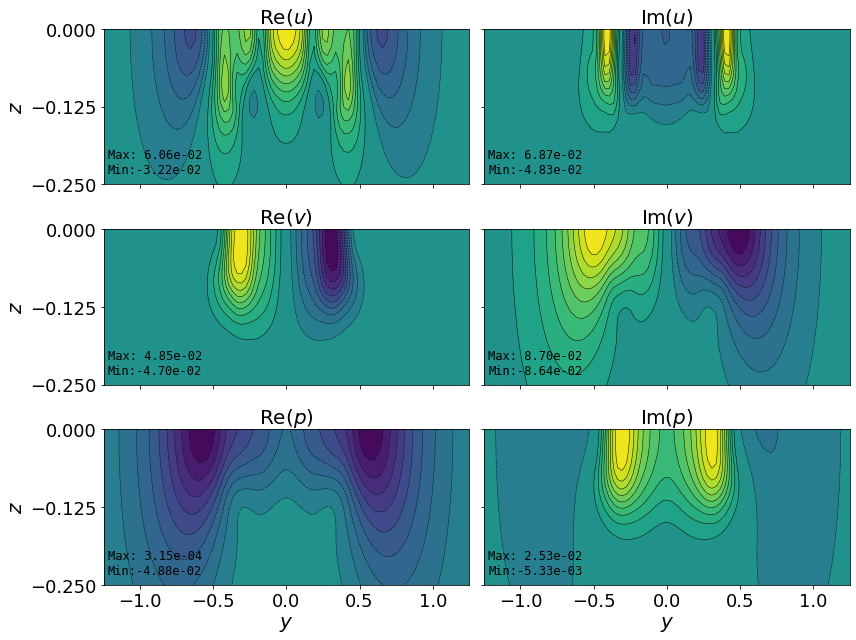

In [45]:
fig, axes=plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(12,9))

levels = np.delete(np.linspace(-1,1,21),10); fontsize=20; labelsize=20

axes[0,0].contourf(Y, Z, u.real/np.amax(abs(u.real)), levels=levels)
axes[0,0].contour(Y, Z, u.real/np.amax(abs(u.real)), colors='k', levels=levels, linewidths=0.5)

axes[1,0].contourf(Y, Z, v.real/np.amax(abs(v.real)), levels=levels)
axes[1,0].contour(Y, Z, v.real/np.amax(abs(v.real)), colors='k', levels=levels, linewidths=0.5)

axes[2,0].contourf(Y, Z, p.real/np.amax(abs(p.real)), levels=levels)
axes[2,0].contour(Y, Z, p.real/np.amax(abs(p.real)), colors='k', levels=levels, linewidths=0.5)

axes[0,1].contourf(Y, Z, u.imag/np.amax(abs(u.imag)), levels=levels)
axes[0,1].contour(Y, Z, u.imag/np.amax(abs(u.imag)), colors='k', levels=levels, linewidths=0.5)

axes[1,1].contourf(Y, Z, v.imag/np.amax(abs(v.imag)), levels=levels)
axes[1,1].contour(Y, Z, v.imag/np.amax(abs(v.imag)), colors='k', levels=levels, linewidths=0.5)

axes[2,1].contourf(Y, Z, p.imag/np.amax(abs(p.imag)), levels=levels)
axes[2,1].contour(Y, Z, p.imag/np.amax(abs(p.imag)), colors='k', levels=levels, linewidths=0.5)

axes[0,0].text(0.14, 0.14, f'Max: {max_u_re}\nMin:{min_u_re}', horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes, family='monospace', fontsize=12)
axes[1,0].text(0.14, 0.14, f'Max: {max_v_re}\nMin:{min_v_re}', horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes, family='monospace', fontsize=12)
axes[2,0].text(0.14, 0.14, f'Max: {max_p_re}\nMin:{min_p_re}', horizontalalignment='center', verticalalignment='center', transform=axes[2,0].transAxes, family='monospace', fontsize=12)
axes[0,1].text(0.14, 0.14, f'Max: {max_u_im}\nMin:{min_u_im}', horizontalalignment='center', verticalalignment='center', transform=axes[0,1].transAxes, family='monospace', fontsize=12)
axes[1,1].text(0.14, 0.14, f'Max: {max_v_im}\nMin:{min_v_im}', horizontalalignment='center', verticalalignment='center', transform=axes[1,1].transAxes, family='monospace', fontsize=12)
axes[2,1].text(0.14, 0.14, f'Max: {max_p_im}\nMin:{min_p_im}', horizontalalignment='center', verticalalignment='center', transform=axes[2,1].transAxes, family='monospace', fontsize=12)

axes[0,0].set_title(r'Re($u$)', fontsize=fontsize); axes[1,0].set_title(r'Re($v$)', fontsize=fontsize); axes[2,0].set_title(r'Re($p$)', fontsize=fontsize)
axes[0,1].set_title(r'Im($u$)', fontsize=fontsize); axes[1,1].set_title(r'Im($v$)', fontsize=fontsize); axes[2,1].set_title(r'Im($p$)', fontsize=fontsize)

axes[2,0].set_xlabel(r'$y$', fontsize=fontsize)
axes[2,1].set_xlabel(r'$y$', fontsize=fontsize)

axes[0,0].set_ylabel(r'$z$', fontsize=fontsize)
axes[1,0].set_ylabel(r'$z$', fontsize=fontsize)
axes[2,0].set_ylabel(r'$z$', fontsize=fontsize)

# For these cases Proehl does not plot the entirety of the domain
if case == 'Proehl_1' or case == 'Proehl_2' or case == 'Proehl_3':
    axes[0,0].set_xlim([-3e5, 0])
    axes[0,0].set_ylim([-800, -200])
    axes[0,0].set_yticks([-800,-600, -400, -200])

elif (
   case == 'Proehl_4' or case == 'Proehl_5' or case == 'Proehl_6' or
   case == 'Proehl_7' or case == 'Proehl_8' 
):
    # axes[0,0].set_xlim([-8e5,8e5])
    # axes[0,0].set_ylim([-250, 0.0])
    # axes[0,0].set_yticks([-250, -125, 0.0])
    
    axes[0,0].set_xlim([(-8e5/Leq),(8e5/Leq)])
    axes[0,0].set_ylim([-0.25, 0.0])
    axes[0,0].set_yticks([-0.25, -0.125, 0.0])

axes[0,0].tick_params(axis='both', which='major', labelsize=18)
axes[1,0].tick_params(axis='both', which='major', labelsize=18)
axes[2,0].tick_params(axis='both', which='major', labelsize=18)
axes[2,1].tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
#plt.savefig(f'/home/rees/lsa/figures/eigenvectors/{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}.png', dpi=600, bbox_inches='tight')
plt.show()

In [3]:
def load_data(ny, nz, k, mu, case, dim):
    
    fname = [f'/home/rees/lsa/eigenvalues/evals_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}_dense.txt',
            f'/home/rees/lsa/eigenvectors/evecs_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}_dense.txt']
    
    evals = np.loadtxt(fname[0]).view(complex).reshape(-1) 
    evecs = np.loadtxt(fname[1]).view(complex).reshape(-1) 
    
    if dim == '2D':
        u = np.reshape(evecs[:(ny-1)*(nz-1)],(ny-1,nz-1)).T
        v = np.reshape(evecs[(ny-1)*(nz-1):(2*ny-1)*(nz-1)],(ny,nz-1)).T
        p = np.reshape(evecs[(2*ny-1)*(nz-1):],(ny-1,nz-1)).T
    
    return evals, u, v, p

In [5]:
evals, u, v, p = load_data(ny, nz, k, mu, case, dim)

In [8]:
L = (10*111.32)*1000; D= 1000
y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz)
dy = abs(y[1]-y[0]); dz = abs(z[1]-z[0])

Y, Z = np.meshgrid(y, z)

r0 = 1026; g = 9.81

In [9]:
rho = np.zeros((nz, ny-1), dtype=complex)
for j in range(ny-1):
    for l in range(nz-2):
        rho[l+1, j] = -(r0/g)*(1/dz)*(p[l+1, j]-p[l, j])

In [18]:
# Calculate domain in order to obtain mean fields

L = (10*111.32)*1000 # Meridional half-width of the domain (m)
D = 1000             # Depth of the domain (m)

y = np.linspace(-L, L, ny); z = np.linspace(-D, 0, nz) 

dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]

Y,Z         = np.meshgrid(y, z);         Y_full,Z_half = np.meshgrid(y, z_mid) 
Y_mid,Z_mid = np.meshgrid(y_mid, z_mid); Y_half,Z_full = np.meshgrid(y_mid, z)

# Typical values for the equatorial ocean 
r0     = 1026              # Background density (kg m^{3})
g      = 9.81              # Gravitational acceleration (ms^{-2})

rho = np.zeros((nz, ny-1), dtype=complex)
for j in range(ny-1):
    for l in range(nz-2):
        rho[l+1, j] = -(r0/g)*(1/dz)*(p[l+1, j]-p[l, j])
        
# Interpolation fails on large domains, so construct a smaller domain with the same grid resolution

y = np.linspace(-1, 1, ny); z = np.linspace(-1, 0, nz)

dy = abs(y[1]-y[0]); y_mid = (y[:y.size] + 0.5*dy)[:-1]
dz = abs(z[1]-z[0]); z_mid = (z[:z.size] + 0.5*dz)[:-1]

Y,Z         = np.meshgrid(y, z);         Y_full,Z_half = np.meshgrid(y, z_mid) 
Y_mid,Z_mid = np.meshgrid(y_mid, z_mid); Y_half,Z_full = np.meshgrid(y_mid, z)

# Construct a new grid on which to interpolate the existing data

new_ny = ny*2; new_nz = nz*2

y_new = np.linspace(y[0], y[-1], new_ny); z_new = np.linspace(z[0], z[-1], new_nz) 

Y_new,Z_new = np.meshgrid(y_new, z_new) 

new_grid = np.stack([Y_new.ravel(), Z_new.ravel()], -1)

# Obtain the grids on which each variable is located

w_grid = np.stack([Y_half.ravel(), Z_full.ravel()], -1)

# Construct an RBF interpolator for each required field

rho_interpolator = interp.RBFInterpolator(w_grid, rho.ravel(), smoothing=0, kernel='cubic')

#rho = rho_interpolator(new_grid).reshape(Y_new.shape)#; w[0,:] = 0; w[-1,:] = 0

fname = f'/home/rees/lsa/interpolated_fields/rho/rho_{case}_{dim}_{ny:02}_{nz:02}_{int(k*100):03}_dense.txt'

#np.savetxt(fname, rho.view(float).reshape(-1, 2))  


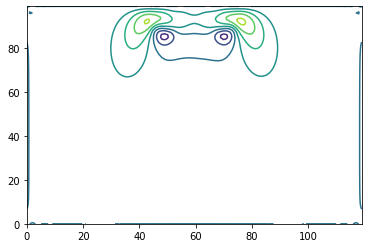

In [26]:
plt.contour(rho.imag)
plt.show()